<a href="https://colab.research.google.com/github/vard-uhi/Yerevan-Apartment-Price-Prediction/blob/master/MLmodel_Yerevan_Apartment_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Yerevan Apartment Price**

We are going to predict Apartment Prices in Yerevan based on scraped data, and for this exercise we will use Linear Regression.

In [1]:
#data manipulation, transformation
import pandas as pd 

#visualization
import matplotlib.pyplot as plt 
import seaborn as sns #visualization

#for scientific computations
import numpy as np 

#for train and test split
from sklearn.model_selection import train_test_split 

#model building in stats
import statsmodels.api as sm

#internal validity stastistical tests and plots
from statsmodels.api import qqplot #for qq plot
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  #variance equality and linearity tests
from scipy.stats import shapiro #for checking normality
from statsmodels.stats.outliers_influence import variance_inflation_factor #for checking Multicolinearity
from sklearn.metrics import r2_score #R-squared

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [134]:
#load the data
from google.colab import files
data_to_load = files.upload()

Saving data_cleaned.csv to data_cleaned (5).csv


In [135]:
import io
# .read_csv() assigns the information from the initial *.csv file to this variable
raw_data = pd.read_csv(io.BytesIO(data_to_load['data_cleaned.csv']))

In [136]:
df = raw_data.copy()

#### **Descriptive Analysis**

In [137]:
#data overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047 entries, 0 to 2046
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Price           2047 non-null   int64 
 1   Total Area(m2)  2047 non-null   int64 
 2   Room Count      2047 non-null   int64 
 3   Floor           2047 non-null   int64 
 4   Condition       2047 non-null   object
 5   Building Type   2047 non-null   object
 6   Balcony Type    2047 non-null   object
 7   District        2047 non-null   object
dtypes: int64(4), object(4)
memory usage: 128.1+ KB


In [138]:
#some statistics about data including categorical variables
df.describe(include='all')

,Price,Total Area(m2),Room Count,Floor,Condition,Building Type,Balcony Type,District
count,2.047000e+03,2047.000000,2047.000000,2047.000000,2047,2047,2047,2047
unique,NaN,NaN,NaN,NaN,6,8,4,12
top,NaN,NaN,NaN,NaN,Repaired,High-rise,Large,Downtown
freq,NaN,NaN,NaN,NaN,1103,570,1095,735
mean,1.461657e+05,99.889106,2.945286,5.103078,NaN,NaN,NaN,NaN
std,1.634760e+05,53.859316,1.044436,3.521422,NaN,NaN,NaN,NaN
min,3.000000e+04,26.000000,1.000000,0.000000,NaN,NaN,NaN,NaN
25%,7.200000e+04,71.000000,2.000000,3.000000,NaN,NaN,NaN,NaN
50%,1.000000e+05,87.000000,3.000000,4.000000,NaN,NaN,NaN,NaN
75%,1.550000e+05,110.000000,3.000000,7.000000,NaN,NaN,NaN,NaN


As we see, our dataset doesn't have many features. It has 2047 rows and 8 features. Our data is not that informative to compare with classical house price prediction “Boston” dataset. Let's continue to see what information we can extract from it and what degree of prediction accuracy we can reach with this sample.

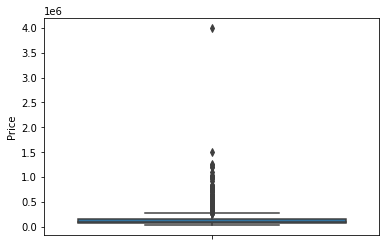

In [139]:
#plotting Price dependent variable
sns.boxplot(y = df['Price'])

In [140]:
df = df[df['Price'] < df['Price'].quantile(0.99)].reset_index(drop=True)

In [141]:
df = df[df['Total Area(m2)'] < df['Total Area(m2)'].quantile(0.98)].reset_index(drop=True)

In [142]:
df.shape

(1983, 8)

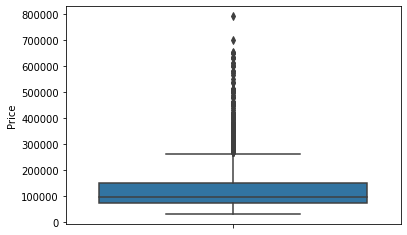

In [143]:
#plotting Price dependent variable
sns.boxplot(y = df['Price'])

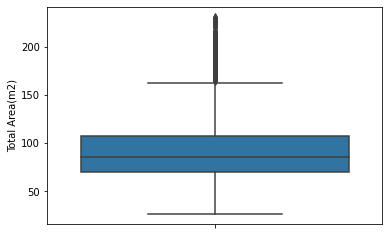

In [144]:
#plotting Price dependent variable
sns.boxplot(y = df['Total Area(m2)'])

In [145]:
#checking for Null values
df.isnull().sum()

Price             0
Total Area(m2)    0
Room Count        0
Floor             0
Condition         0
Building Type     0
Balcony Type      0
District          0
dtype: int64

We don't have Null values.

However, we have outliers in our data. I have tried to delete some percent and played with other features as well, because we have outliers also in the 'Total Area' feature. As our data is not so big, deleting some portion of it only harms our model. That is why we will keep all rows.

In [146]:
#checking whether there are columns having same value for all observations
df.columns[df.nunique()==1]

Index([], dtype='object')

In [147]:
#checking for duplicates
print(df[df.duplicated()])
print(df.duplicated().any())

       Price  Total Area(m2)  ...  Balcony Type          District
48    169000              96  ...         Large          Downtown
123    43000              49  ...         Large              Nork
146    37500              59  ...         Large              Nork
321   144100             131  ...        Lodgia    Kanaker-Zeitun
330    49500              55  ...        Lodgia    Kanaker-Zeitun
331    55000              55  ...        Lodgia    Kanaker-Zeitun
332    55000              55  ...        Lodgia    Kanaker-Zeitun
333    57750              55  ...        Lodgia    Kanaker-Zeitun
334    57750              55  ...        Lodgia    Kanaker-Zeitun
335    52200              58  ...        Lodgia    Kanaker-Zeitun
336    52200              58  ...        Lodgia    Kanaker-Zeitun
337    58000              58  ...        Lodgia    Kanaker-Zeitun
338    58000              58  ...        Lodgia    Kanaker-Zeitun
339    60900              58  ...        Lodgia    Kanaker-Zeitun
340    609

We have duplicate values. We will drop them as Linear Regression assumes independence of observations.

In [148]:
#drop duplicates
df.drop_duplicates(keep = 'first', inplace = True)

In [149]:
#checking again for duplicates
print(df[df.duplicated()])
print(df.duplicated().any())

Empty DataFrame
Columns: [Price, Total Area(m2), Room Count, Floor, Condition, Building Type, Balcony Type, District]
Index: []
False


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1930 entries, 0 to 1982
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Price           1930 non-null   int64 
 1   Total Area(m2)  1930 non-null   int64 
 2   Room Count      1930 non-null   int64 
 3   Floor           1930 non-null   int64 
 4   Condition       1930 non-null   object
 5   Building Type   1930 non-null   object
 6   Balcony Type    1930 non-null   object
 7   District        1930 non-null   object
dtypes: int64(4), object(4)
memory usage: 135.7+ KB


In [151]:
#reset indexes after deleting duplicates
df = df.reset_index(drop=True)

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Price           1930 non-null   int64 
 1   Total Area(m2)  1930 non-null   int64 
 2   Room Count      1930 non-null   int64 
 3   Floor           1930 non-null   int64 
 4   Condition       1930 non-null   object
 5   Building Type   1930 non-null   object
 6   Balcony Type    1930 non-null   object
 7   District        1930 non-null   object
dtypes: int64(4), object(4)
memory usage: 120.8+ KB


As we have dropped duplicates, now our dataset has less data.

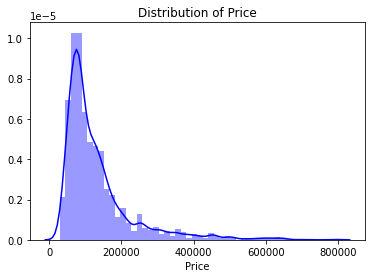

In [153]:
# Visualising Distribution of Price
sns.distplot(df['Price'],color="blue")
plt.title("Distribution of Price")
plt.show()

In [154]:
# Let's check skewness
df['Price'].skew()

2.5074843635332456

We have right skewness in our dependent variable. Which means data is distributed asymmetric and mean is greater than median. However, we are not going to delete outliers, because we will transform our data to log values and will get rid of this large skewness.

Text(0.5, 1.0, 'Price and Flour')

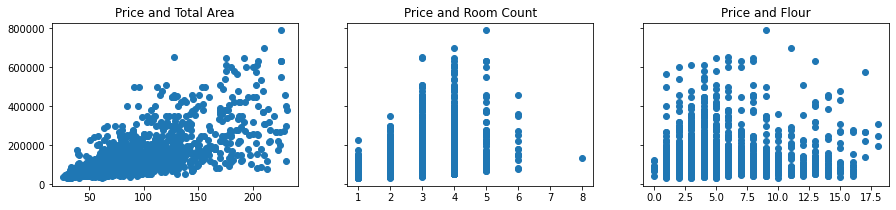

In [155]:
# Comparing Price with other numeric features
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = (15,3))
ax1.scatter(df['Total Area(m2)'], df['Price'])
ax1.set_title('Price and Total Area')
ax2.scatter(df['Room Count'], df['Price'])
ax2.set_title('Price and Room Count')
ax3.scatter(df['Floor'], df['Price'])
ax3.set_title('Price and Flour')

In [156]:
#transforming to log value
log_price = np.log(df['Price'])

In [157]:
# Adding new column named log_price
df['Log Price'] = log_price

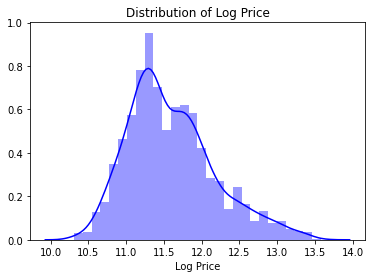

In [158]:
# Visualising Distribution of Log of Price
sns.distplot(df['Log Price'],color="blue")
plt.title("Distribution of Log Price")
plt.show()

In [159]:
# Let's check our skewness now
df['Log Price'].skew()

0.6897837353796559

Current symmetry of distribution is acceptable.

Text(0.5, 1.0, 'Log Price and Flour')

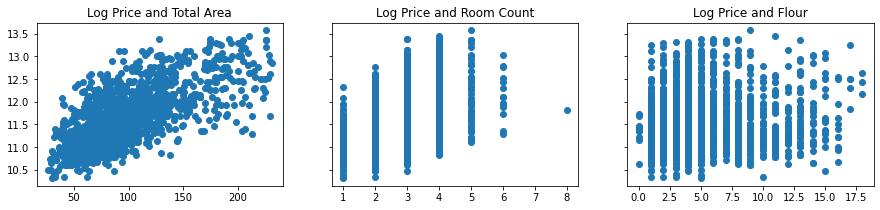

In [160]:
#Comparing Lof of Price with other numeric features
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = (15,3))
ax1.scatter(df['Total Area(m2)'], df['Log Price'])
ax1.set_title('Log Price and Total Area')
ax2.scatter(df['Room Count'], df['Log Price'])
ax2.set_title('Log Price and Room Count')
ax3.scatter(df['Floor'], df['Log Price'])
ax3.set_title('Log Price and Flour')

As we transformed Price to Log Price, now we clearly see linearity in our data, which is one of the OLS assumptions of the Linear Regression model, which now we can say is checked.

In [161]:
df.head()

,Price,Total Area(m2),Room Count,Floor,Condition,Building Type,Balcony Type,District,Log Price
0,52000,66,2,4,Repaired,High-rise,Large,Erebuni,10.858999
1,130000,90,3,2,Repaired,Stone,Large,Downtown,11.775290
2,80000,42,1,3,Repaired,High-rise,Large,Downtown,11.289782
3,55000,37,1,9,3-5 Years,High-rise,Lodgia,Downtown,10.915088
4,47000,63,2,8,Repaired,High-rise,Large,Nork,10.757903


As we are going to conduct some exploratory data analysis on Price, we will drop this column later, to avoid multicollinearity.

**Visualisation**

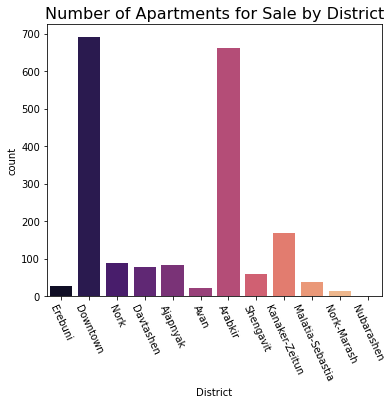

In [162]:
#let's see Number of Apartments by District
plt.figure(figsize=(6,5))
cp=sns.countplot(x="District",data=df, palette='magma',orient="v")
cp.set_xticklabels(cp.get_xticklabels(),rotation=-65)
plt.xlabel("District")
plt.title("Number of Apartments for Sale by District",fontdict={"fontsize":16})
plt.show()

In [163]:
#Let's also see mean price by District using groupby method
district_df = df.groupby(by='District').mean().round(0)

In [164]:
district_df

,Price,Total Area(m2),Room Count,Floor,Log Price
District,,,,,
Ajapnyak,71738.0,90.0,3.0,5.0,11.0
Arabkir,112982.0,91.0,3.0,5.0,12.0
Avan,67095.0,88.0,3.0,5.0,11.0
Davtashen,118205.0,100.0,3.0,7.0,12.0
Downtown,190334.0,102.0,3.0,5.0,12.0
Erebuni,59241.0,72.0,2.0,5.0,11.0
Kanaker-Zeitun,82918.0,87.0,3.0,6.0,11.0
Malatia-Sebastia,63590.0,81.0,3.0,5.0,11.0
Nork,74856.0,85.0,3.0,4.0,11.0


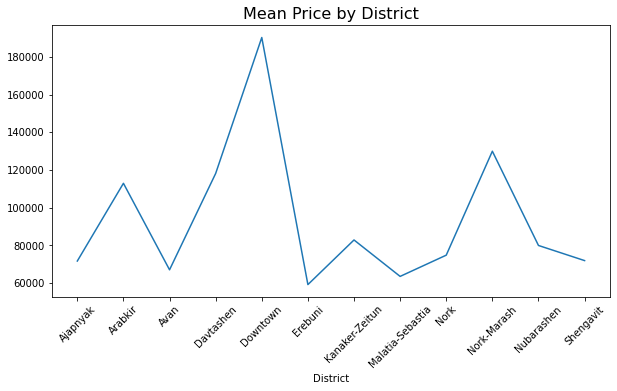

In [165]:
#let's see the mean price by District
plt.figure(figsize = (10,5))
plt.plot(district_df.Price)
plt.xlabel("District")
plt.xticks(rotation = 45)
plt.title("Mean Price by District",fontdict = {"fontsize":16})
plt.show()

In [166]:
# To avoid moticoliniarity, we should drop Price and continue with Log Price
data = df.drop(['Price'], axis=1)

In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Total Area(m2)  1930 non-null   int64  
 1   Room Count      1930 non-null   int64  
 2   Floor           1930 non-null   int64  
 3   Condition       1930 non-null   object 
 4   Building Type   1930 non-null   object 
 5   Balcony Type    1930 non-null   object 
 6   District        1930 non-null   object 
 7   Log Price       1930 non-null   float64
dtypes: float64(1), int64(3), object(4)
memory usage: 120.8+ KB


In [168]:
data.head()

,Total Area(m2),Room Count,Floor,Condition,Building Type,Balcony Type,District,Log Price
0,66,2,4,Repaired,High-rise,Large,Erebuni,10.858999
1,90,3,2,Repaired,Stone,Large,Downtown,11.775290
2,42,1,3,Repaired,High-rise,Large,Downtown,11.289782
3,37,1,9,3-5 Years,High-rise,Lodgia,Downtown,10.915088
4,63,2,8,Repaired,High-rise,Large,Nork,10.757903


#### **Model selection**

In [169]:
#lets see the corrplot
data.corr()

,Total Area(m2),Room Count,Floor,Log Price
Total Area(m2),1.000000,0.771457,0.068633,0.682007
Room Count,0.771457,1.000000,0.016102,0.452353
Floor,0.068633,0.016102,1.000000,0.058133
Log Price,0.682007,0.452353,0.058133,1.000000


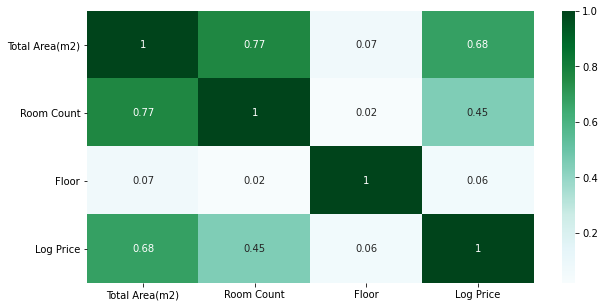

In [170]:
#Let's visualize correlations
plt.figure(figsize=(10,5))
sns.heatmap(data.corr().abs().round(2),annot=True, cmap = "BuGn")
plt.show()

There are strong correlation between 'Total Area' & 'Log Price' and 'Total Area' & 'Room Count'.

**Checking Multicollinearity**

Checking for another Linear Regression OLS assumption.

It is obvious that ‘Total Area’ and ‘Room Count’ are dependent. Let's check this with the VIF method.


In [171]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = data[['Total Area(m2)', 'Room Count', 'Floor']]
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns

In [172]:
vif

,vif,features
0,18.260793,Total Area(m2)
1,18.728494,Room Count
2,2.646985,Floor


As we see, they have high values, which means we should delete one that has the highest value.

In [173]:
data_no_multicolinearity = data.drop(['Room Count'], axis=1)

In [174]:
data_no_multicolinearity.head()

,Total Area(m2),Floor,Condition,Building Type,Balcony Type,District,Log Price
0,66,4,Repaired,High-rise,Large,Erebuni,10.858999
1,90,2,Repaired,Stone,Large,Downtown,11.775290
2,42,3,Repaired,High-rise,Large,Downtown,11.289782
3,37,9,3-5 Years,High-rise,Lodgia,Downtown,10.915088
4,63,8,Repaired,High-rise,Large,Nork,10.757903


**Creating dummy variables for our categorical variables**

In [175]:
data_with_dummies = pd.get_dummies(data_no_multicolinearity, drop_first=True)

In [176]:
data_with_dummies.head()

,Total Area(m2),Floor,Log Price,Condition_3-5 Years,Condition_Needs Repairing,Condition_Original,Condition_Repaired,Condition_Ruins,Building Type_High-rise,"Building Type_Khrushchev(2,5-2,6м)","Building Type_Khrushchev(2,75м)",Building Type_New Building,Building Type_Panel(5floor),Building Type_Stalinian,Building Type_Stone,Balcony Type_Front,Balcony Type_Large,Balcony Type_Lodgia,District_Arabkir,District_Avan,District_Davtashen,District_Downtown,District_Erebuni,District_Kanaker-Zeitun,District_Malatia-Sebastia,District_Nork,District_Nork-Marash,District_Nubarashen,District_Shengavit
0,66,4,10.858999,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,90,2,11.775290,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,42,3,11.289782,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,37,9,10.915088,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,63,8,10.757903,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [177]:
data_with_dummies["Total Area"] = np.sqrt(data_with_dummies["Total Area(m2)"])

In [178]:
data_with_dummies.head()

,Total Area(m2),Floor,Log Price,Condition_3-5 Years,Condition_Needs Repairing,Condition_Original,Condition_Repaired,Condition_Ruins,Building Type_High-rise,"Building Type_Khrushchev(2,5-2,6м)","Building Type_Khrushchev(2,75м)",Building Type_New Building,Building Type_Panel(5floor),Building Type_Stalinian,Building Type_Stone,Balcony Type_Front,Balcony Type_Large,Balcony Type_Lodgia,District_Arabkir,District_Avan,District_Davtashen,District_Downtown,District_Erebuni,District_Kanaker-Zeitun,District_Malatia-Sebastia,District_Nork,District_Nork-Marash,District_Nubarashen,District_Shengavit,Total Area
0,66,4,10.858999,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,8.124038
1,90,2,11.775290,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,9.486833
2,42,3,11.289782,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,6.480741
3,37,9,10.915088,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,6.082763
4,63,8,10.757903,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,7.937254


In [179]:
data_with_dummies = data_with_dummies.drop(['Total Area(m2)'], axis=1)

#### **ML Model**

In [180]:
#setting the independent and dependent varables
inputs = data_with_dummies.drop(['Log Price'], axis=1)
inputs.shape

(1930, 28)

In [181]:
target = data_with_dummies['Log Price']
target.shape

(1930,)

In [182]:
# Splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size = 0.2, random_state=42)

In [183]:
#importing Linear Regression module
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

In [184]:
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [185]:
#prediction
y_hat = reg.predict(x_train)

Text(0, 0.5, 'Predictions (y_hat)')

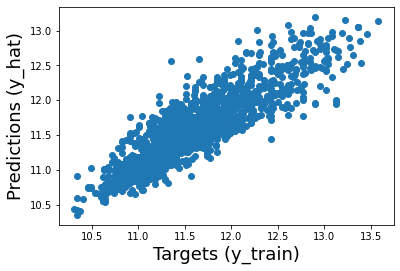

In [186]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_train, y_hat)
# Let's also name the axes
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)

In [187]:
#predicting on test data
y_hat_test = reg.predict(x_test)

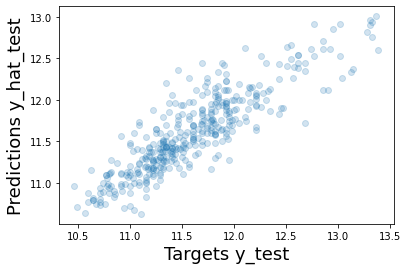

In [188]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets y_test', size = 18)
plt.ylabel('Predictions y_hat_test',size = 18)
plt.show()

In [189]:
# R2 for train and test data
R2_reg_train = reg.score(x_train,y_train)
R2_reg_test = reg.score(x_test,y_test)
print('R squared for train data is: %.3f' %(R2_reg_train))
print('R squared for test data is: %.3f' %(R2_reg_test))

R squared for train data is: 0.774
R squared for test data is: 0.765


In [190]:
from sklearn.metrics import median_absolute_error

In [191]:
median_absolute_error(y_test, y_hat_test)

0.1583988902303215

In [192]:
reg.coef_

array([-3.12544139e-03, -9.30039959e-02, -3.60922584e-01, -2.24186801e-01,
       -9.59277504e-02, -4.25022150e-01, -9.83730049e-02, -9.81579837e-02,
       -6.70442122e-02,  2.79091407e-01, -3.82566697e-02,  1.30483072e-01,
       -6.47564821e-05,  2.25605263e-01,  1.71595558e-01,  2.17611650e-01,
        3.54854974e-01,  8.26490089e-02,  3.20249618e-01,  6.71607830e-01,
        4.36556477e-02, -3.03096519e-04,  9.01789255e-02,  6.30434380e-02,
        6.23425884e-02, -4.40707301e-03,  4.61401784e-02,  1.67199559e-01])

In [193]:
reg.intercept_

9.487643407610955

**Summary Table**

In [194]:
#summary table
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_

In [195]:
#positive coefficients
pos_coeffs= reg_summary[(reg_summary['Weights'] >= 0)].sort_values(by='Weights', ascending=False)

In [196]:
pos_coeffs

,Features,Weights
19,District_Downtown,0.671608
16,District_Arabkir,0.354855
18,District_Davtashen,0.320250
9,Building Type_New Building,0.279091
13,Balcony Type_Front,0.225605
15,Balcony Type_Lodgia,0.217612
14,Balcony Type_Large,0.171596
27,Total Area,0.167200
11,Building Type_Stalinian,0.130483
22,District_Malatia-Sebastia,0.090179


In [197]:
# negative coefficients
neg_coeffs= reg_summary[(reg_summary['Weights'] < 0)].sort_values(by='Weights', ascending=True)

In [198]:
neg_coeffs

,Features,Weights
5,Condition_Ruins,-0.425022
2,Condition_Needs Repairing,-0.360923
3,Condition_Original,-0.224187
6,Building Type_High-rise,-0.098373
7,"Building Type_Khrushchev(2,5-2,6м)",-0.098158
4,Condition_Repaired,-0.095928
1,Condition_3-5 Years,-0.093004
8,"Building Type_Khrushchev(2,75м)",-0.067044
10,Building Type_Panel(5floor),-0.038257
25,District_Nubarashen,-0.004407


#### **Checking OLS Assumptions**

**Residual Plots**

It should not exhibit any patterns (should be randomly distributed) to meet the Linearity, Normality and Independence assumptions.

In [199]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


0.7647090423666243

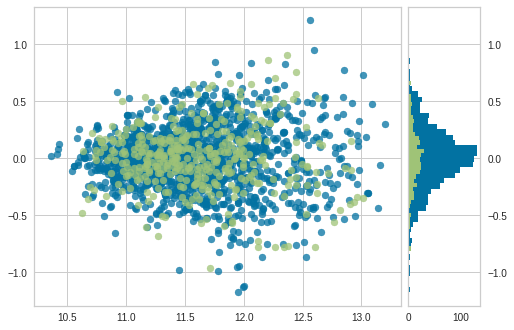

In [200]:
visualizer = ResidualsPlot(reg)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)

Text(0.5, 1.0, 'Residual Plot using train data')

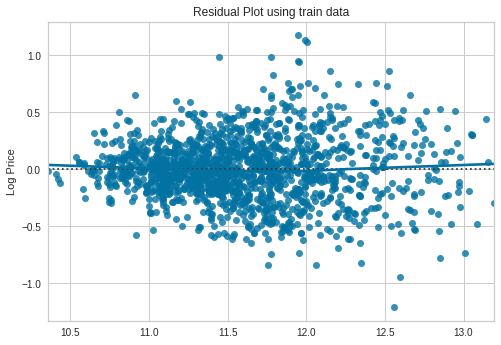

In [201]:
#Residual Plot for Train data
sns.residplot(x=reg.predict(x_train), y=y_train, lowess=True)
plt.title('Residual Plot using train data')

Residual plot for the training data shows that the data points lie between Log Price -0.5 to 0.5.

The residuals vs fitted values plot pattern is random and we cannot see an increasing/decreasing variance.

Text(0.5, 1.0, 'Residual Plot using test data')

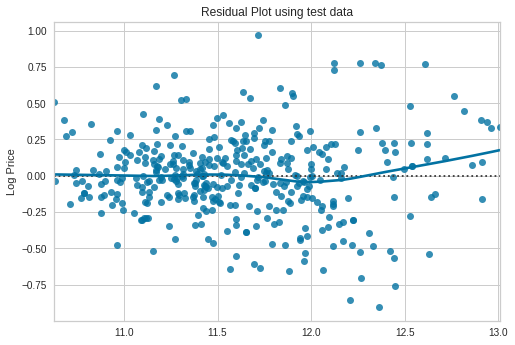

In [202]:
# Residual Plot for Test data
sns.residplot(x=reg.predict(x_test), y=y_test, lowess=True)
plt.title('Residual Plot using test data')

Test data is also showing the same range from the reference line.

Text(0, 0.5, 'Residuals')

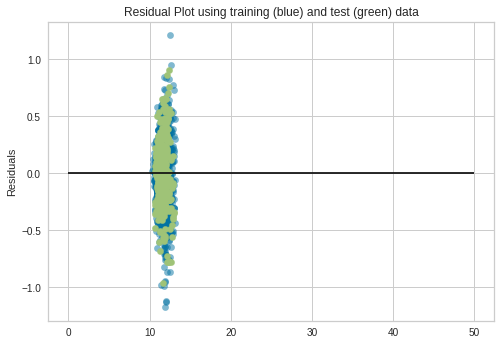

In [203]:
#2 residual plots on top of each other
plt.scatter(reg.predict(x_train), reg.predict(x_train) - y_train, c='b', s=40, alpha=0.5)
plt.scatter(reg.predict(x_test), reg.predict(x_test) - y_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax = 50)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

The blue dots represent train data and grren dots represent test data. From the residual plot above it is evident that the model is a good fit for test data as well. 

#### **Performance**

In [204]:
df_performance = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])

In [205]:
df_performance.head()

,Prediction
0,117996.905530
1,52369.124424
2,80066.549074
3,57721.343402
4,65905.056935


In [206]:
df_performance['Target'] = np.exp(y_test)

In [207]:
df_performance.head()

,Prediction,Target
0,117996.905530,NaN
1,52369.124424,NaN
2,80066.549074,NaN
3,57721.343402,NaN
4,65905.056935,NaN


In [208]:
y_test = y_test.reset_index(drop = True)

In [209]:
y_test.head()

0    11.775290
1    10.858999
2    11.156251
3    10.819778
4    10.772687
Name: Log Price, dtype: float64

In [210]:
df_performance['Target'] = np.exp(y_test)

In [211]:
df_performance.head()

,Prediction,Target
0,117996.905530,130000.0
1,52369.124424,52000.0
2,80066.549074,70000.0
3,57721.343402,50000.0
4,65905.056935,47700.0


In [213]:
df_performance['Residual'] = df_performance['Target'] - df_performance['Prediction']

In [214]:
df_performance['Difference%'] = np.absolute(df_performance['Residual']/df_performance['Target']*100)

In [215]:
df_performance.head()

,Prediction,Target,Residual,Difference%
0,117996.905530,130000.0,12003.094470,9.233150
1,52369.124424,52000.0,-369.124424,0.709855
2,80066.549074,70000.0,-10066.549074,14.380784
3,57721.343402,50000.0,-7721.343402,15.442687
4,65905.056935,47700.0,-18205.056935,38.165738


In [216]:
df_performance.describe()

,Prediction,Target,Residual,Difference%
count,386.000000,386.000000,386.000000,386.000000
mean,126622.939703,133343.782383,6720.842680,21.930900
std,72532.979690,103171.909749,55675.494563,21.289568
min,41141.710176,35000.000000,-139299.610779,0.119186
25%,77777.147011,75000.000000,-13680.815437,7.322048
50%,106842.621908,102000.000000,-1069.687634,16.141859
75%,153548.249376,150000.000000,17024.653962,28.578508
max,446527.791040,650000.000000,351169.064471,146.631169


In [217]:
df_performance.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
37,91890.348733,92000.0,109.651267,0.119186
97,88368.466500,88200.0,-168.466500,0.191005
146,82222.067048,82000.0,-222.067048,0.270813
204,163561.793876,163000.0,-561.793876,0.344659
339,149431.409665,150000.0,568.590335,0.379060
...,...,...,...,...
79,144817.903629,75000.0,-69817.903629,93.090538
171,211914.011640,105000.0,-106914.011640,101.822868
190,254627.610160,120000.0,-134627.610160,112.189675
326,200361.907257,85000.0,-115361.907257,135.719891
